In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
from sklearn.decomposition import PCA, IncrementalPCA
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', '20190218.csv', '20190219.csv', 'accurate.xlsx', 'comments.txt', 'cst1.csv', 'cst2.csv', 'document.csv', 'dot.csv', 'dot_result.csv']


In [2]:
dot_data_1 = pd.read_csv(path + '20190219.csv', header = None, names = ['dot', 'order_date', 'order_num'])
dot_data_2 = pd.read_csv(path + 'dot.csv', header = None, names = ['dot', 'dot_type', 'area', 'city_code', 'department', 'province', 'city', 'district', 'town', 'village'])


In [3]:
dot_data_1['order_date'] = pd.to_datetime(dot_data_1['order_date'])
dot_data_1 = dot_data_1[dot_data_1['order_date'] >= pd.to_datetime('2017-12-01')]
dot_data_1 = dot_data_1[dot_data_1['order_date'] <= pd.to_datetime('2019-01-31')]
dot_data_1.head()

,dot,order_date,order_num
155652,大朗卢屋点部,2017-12-01,51
155653,大连开发区点部,2017-12-01,9
155654,天宁遥观点部,2017-12-01,49
155655,天津一级装卸组,2017-12-01,192
155656,太仓徐行点部,2017-12-01,35


In [8]:
dot_data_1[dot_data_1['dot'] == '相城洋沟娄点部'].sort_values(by = 'order_num').tail()

,dot,order_date,order_num
581191,相城洋沟娄点部,2018-07-28,8171
829741,相城洋沟娄点部,2018-11-11,8571
710983,相城洋沟娄点部,2018-09-23,9531
835796,相城洋沟娄点部,2018-11-13,9572
833158,相城洋沟娄点部,2018-11-12,10449


In [5]:
dot_data_1.dropna(axis = 0, inplace = True)

In [6]:
dot_data_1.isnull().sum()

dot           0
order_date    0
order_num     0
dtype: int64

In [7]:
dot_data_1.head()

,dot,order_date,order_num
155652,大朗卢屋点部,2017-12-01,51
155653,大连开发区点部,2017-12-01,9
155654,天宁遥观点部,2017-12-01,49
155655,天津一级装卸组,2017-12-01,192
155656,太仓徐行点部,2017-12-01,35


In [41]:
data_count = pd.DataFrame(dot_data_1['order_date'].groupby(dot_data_1['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 400, ['dot']]
# len(useful_dot_name)
useful_dot_name.head()

,dot
31,上虞上浦点部
32,上虞东关点部
36,上虞小越点部
38,上虞崧厦点部
66,东丽机场点部


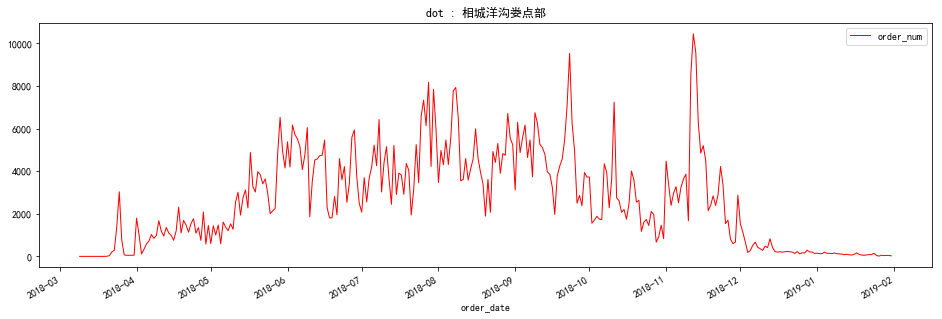

In [48]:
plt.rcParams['font.sans-serif']=['SimHei']
dot_ts = dot_data_1.copy()
dot_ts.index = dot_ts['order_date']
result_ts = dot_ts.loc[dot_ts['dot'] == '相城洋沟娄点部', ['order_num']]
# result_ts = np.log(result_ts)
# result_ts = result_ts['order_num'].resample('D').sum()
result_ts.plot(figsize = (16,5), color = 'r', linewidth=1, title = "dot : 相城洋沟娄点部")

In [10]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = dot_data_1.loc[dot_data_1['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2019-01-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [11]:
dot_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292495 entries, 0 to 292494
Data columns (total 4 columns):
order_date    292495 non-null datetime64[ns]
dot           292495 non-null object
dot_id        292495 non-null int64
order_num     292495 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.9+ MB


In [14]:
dot_preprocessing['order_date'].groupby(dot_preprocessing['dot']).count().describe()

count    685.0
mean     427.0
std        0.0
min      427.0
25%      427.0
50%      427.0
75%      427.0
max      427.0
Name: order_date, dtype: float64

In [15]:
dot_prep = dot_preprocessing.copy()
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,order_date,dot,dot_id,order_num
0,2017-12-01,上虞上浦点部,1,2.708050
26901,2017-12-01,南山西丽点部,64,4.919981
265594,2017-12-01,闵行点部,623,3.784190
112728,2017-12-01,张江陆家嘴点部,265,2.197225
179767,2017-12-01,温岭金清点部,422,1.098612


In [12]:
dot_data_2.head()

,dot,dot_type,area,city_code,department,province,city,district,town,village
0,清江新下塘点部,大点部,华东,577,清江操作部,浙江省,温州市,乐清市,城东街道,新下塘村
1,香洲洪湾点部,大点部,华南,756,香洲操作部,广东省,珠海市,香洲区,南屏镇,洪湾社区
2,贵阳三甫点部,大点部,华北,851,贵阳操作部,贵州省,贵阳市,观山湖区,金华镇,三甫村
3,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村
4,三水竹山点部,大点部,华南,757,三水操作部,广东省,佛山市,三水区,乐平镇,竹山村


In [19]:
dot_data = pd.merge(dot_data_2, dot_prep, how = 'left', on = 'dot')
dot_data.head()

,dot,dot_type,area,city_code,department,province,city,district,town,village,order_date,dot_id,order_num
0,清江新下塘点部,大点部,华东,577,清江操作部,浙江省,温州市,乐清市,城东街道,新下塘村,NaT,NaN,NaN
1,香洲洪湾点部,大点部,华南,756,香洲操作部,广东省,珠海市,香洲区,南屏镇,洪湾社区,NaT,NaN,NaN
2,贵阳三甫点部,大点部,华北,851,贵阳操作部,贵州省,贵阳市,观山湖区,金华镇,三甫村,NaT,NaN,NaN
3,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村,2017-12-01,612.0,2.564949
4,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村,2017-12-02,612.0,2.639057


In [21]:
dot_data.loc[dot_data['city'].isnull(), ['city']] = dot_data.loc[dot_data['city'].isnull(), ['province']].values
dot_data.loc[dot_data['district'].isnull(), ['district']] = dot_data.loc[dot_data['district'].isnull(), ['city']].values

In [23]:
dot_data.dropna(axis = 0, inplace = True)
dot_data.sort_values(by = 'order_date', ascending = True, inplace = True)

In [24]:
dot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289506 entries, 3 to 291469
Data columns (total 13 columns):
dot           289506 non-null object
dot_type      289506 non-null object
area          289506 non-null object
city_code     289506 non-null int64
department    289506 non-null object
province      289506 non-null object
city          289506 non-null object
district      289506 non-null object
town          289506 non-null object
village       289506 non-null object
order_date    289506 non-null datetime64[ns]
dot_id        289506 non-null float64
order_num     289506 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 30.9+ MB


In [25]:
dot_data.head()

,dot,dot_type,area,city_code,department,province,city,district,town,village,order_date,dot_id,order_num
3,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村,2017-12-01,612.0,2.564949
21079,寮步横坑点部,大点部,华南,769,寮步操作部,广东省,东莞市,东莞市,寮步镇,霞边村,2017-12-01,234.0,4.882802
211032,龙华石龙点部,大点部,华南,755,龙华操作部,广东省,深圳市,宝安区,石岩街道,水田社区,2017-12-01,678.0,4.762174
211460,淀山湖宏洋点部,大点部,华东,512,淀山湖操作部,江苏省,苏州市,昆山市,千灯镇,支浦村,2017-12-01,410.0,3.295837
211891,北仑大碶点部,大点部,华东,574,北仑操作部,浙江省,宁波市,北仑区,大碶街道,横杨社区,2017-12-01,49.0,3.401197


In [26]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    return dot_prep_1

def create_feature(data):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [27]:
dot_prep_feature = create_feature(dot_data)

In [28]:
dot_prep_feature.columns

Index(['dot', 'dot_type', 'area', 'city_code', 'department', 'province',
       'city', 'district', 'town', 'village', 'order_date', 'dot_id',
       'order_num', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
       'weekofyear', 'weekofsun', 'holidays', 'lagging1', 'lagging2',
       'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3',
       'rolling5', 'rolling7'],
      dtype='object')

In [31]:
dot_res_tmp = dot_prep_feature.drop(['department', 'city', 'district', 'town', 'village'], axis = 1)
dot_res_tmp.head()

,dot,dot_type,area,city_code,province,order_date,dot_id,order_num,year,month,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
0,罗湖莲塘点部,大点部,华南,755,广东省,2017-12-08,562.0,5.411646,2017,12,...,4.615121,4.897840,4.727388,4.948760,4.077537,4.418841,4.709530,4.746783,4.653329,4.627859
447,上虞崧厦点部,大点部,华东,575,浙江省,2017-12-08,4.0,2.772589,2017,12,...,2.772589,2.772589,2.772589,2.772589,2.772589,2.772589,2.772589,2.772589,2.772589,2.772589
448,甪直澄北点部,大点部,华东,512,江苏省,2017-12-08,482.0,3.871201,2017,12,...,3.465736,3.610918,3.610918,3.258097,2.564949,3.496508,3.465736,3.562524,3.302124,3.353266
449,盐城滨海点部,大点部,华东,515,江苏省,2017-12-08,493.0,1.945910,2017,12,...,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910
450,天河元岗点部,大点部,华南,20,广东省,2017-12-08,180.0,5.049856,2017,12,...,4.828314,5.337538,5.209486,4.532599,5.267858,4.990433,5.342334,5.125113,5.035159,5.072652


In [33]:
dot_res = pd.concat([dot_res_tmp, pd.get_dummies(dot_res_tmp['dot_type']), pd.get_dummies(dot_res_tmp['area']), pd.get_dummies(dot_res_tmp['province'])], axis = 1)
dot_res.drop(['dot_type', 'area', 'province'], axis = 1, inplace = True)
dot_res.head()

,dot,city_code,order_date,dot_id,order_num,year,month,day,dayofweek,dayofyear,...,广西,江苏省,江西省,河北省,河南省,浙江省,湖北省,福建省,贵州省,辽宁省
0,罗湖莲塘点部,755,2017-12-08,562.0,5.411646,2017,12,8,4,342,...,0,0,0,0,0,0,0,0,0,0
447,上虞崧厦点部,575,2017-12-08,4.0,2.772589,2017,12,8,4,342,...,0,0,0,0,0,1,0,0,0,0
448,甪直澄北点部,512,2017-12-08,482.0,3.871201,2017,12,8,4,342,...,0,1,0,0,0,0,0,0,0,0
449,盐城滨海点部,515,2017-12-08,493.0,1.945910,2017,12,8,4,342,...,0,1,0,0,0,0,0,0,0,0
450,天河元岗点部,20,2017-12-08,180.0,5.049856,2017,12,8,4,342,...,0,0,0,0,0,0,0,0,0,0


In [39]:
dot_res.columns

Index(['dot', 'city_code', 'order_date', 'dot_id', 'order_num', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省'],
      dtype='object')

In [40]:
dot_train = dot_res[: -(30 * 338)]
dot_test = dot_res[-(30 * 338) :]

In [41]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [42]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [43]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [44]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-19 18:01:22
train_end :  2019-02-19 18:31:26
city_code 	 0.03500113
dot_id 	 0.050237183
year 	 0.0042918455
month 	 0.01306754
day 	 0.057239667
dayofweek 	 0.065541
dayofyear 	 0.07895866
weekofyear 	 0.012401175
weekofsun 	 0.0056245765
holidays 	 0.030754462
lagging1 	 0.09603569
lagging2 	 0.06069573
lagging3 	 0.04788796
lagging4 	 0.04744748
lagging5 	 0.05044048
lagging6 	 0.054190196
lagging7 	 0.08312627
rolling3 	 0.06025525
rolling5 	 0.047300655
rolling7 	 0.05894511
大点部 	 0.003320533
小点部 	 0.0007454258
航空组 	 0.00088095776
京津冀 	 0.001197199
华东 	 0.0015360289
华北 	 0.0018861531
华南 	 0.001332731
上海 	 0.004178902
北京 	 0.00016941495
四川省 	 0.0005421279
天津 	 0.00050824485
安徽省 	 0.0008922521
山东省 	 0.00058730517
广东省 	 0.0029704089
广西 	 0.00042918455
江苏省 	 0.0030268806
江西省 	 0.00010164897
河北省 	 0.0019426248
河南省 	 0.00070024846
浙江省 	 0.011520217
湖北省 	 0.00075672014
福建省 	 0.0002597696
贵州省 	 0.0
辽宁省 	 0.0010729614


## 预测方式1

In [54]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : np.expm1(y_test), 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(np.expm1(y_test), np.expm1(y_pre))
    result['MAE'] = MAE(np.expm1(y_test), np.expm1(y_pre))
    print("MAE : ", MAE(np.expm1(y_test), np.expm1(y_pre)), " RMSE : ", RMSE(np.expm1(y_test), np.expm1(y_pre)))
#     result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
#     result['RMSE'] = RMSE(y_test, y_pre)
#     result['MAE'] = MAE(y_test, y_pre)
#     print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
#     result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [55]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-19 20:36:16
predict_end :  2019-02-19 20:36:18
MAE :  18.279778232964773  RMSE :  47.94892030452914


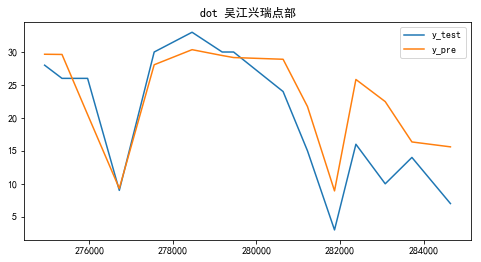

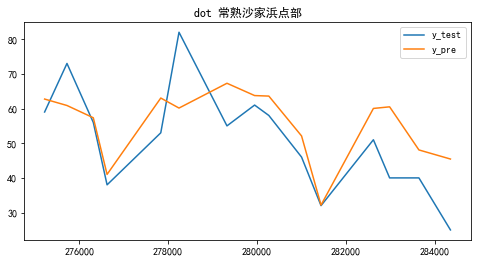

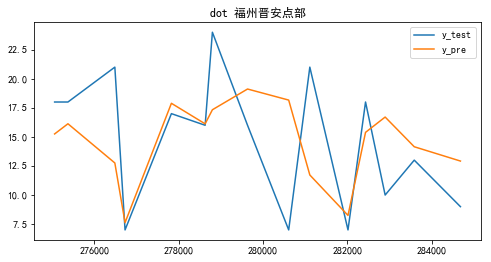

In [48]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

## 预测方式2

In [49]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name['dot']:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [50]:
dot_train.columns

Index(['dot', 'city_code', 'order_date', 'dot_id', 'order_num', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省'],
      dtype='object')

In [ ]:
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
result_to_csv = pd.DataFrame()
org_test = dot_train.copy()
feature = ['dot', 'city_code', 'order_date', 'dot_id', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省']
feature_num = ['dot', 'city_code', 'order_date', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省']
feature_date = ['dot', 'city_code', 'order_date', 'dot_id', 'order_num', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省']
for i in range(30):
    print(i)
    x_test = pre_feature(org_test, useful_dot_name)
    last_train_date = pd.to_datetime('2018-12-01') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, feature]#.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    x_test = x_test[feature_num]

    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'order_num' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot', 'order_date'], how = 'left')
    x_test = x_test[feature_date]
    
    org_test = pd.concat([org_test, x_test])
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
result_to_csv['order_num'] = np.expm1(result_to_csv['order_num'])
result_to_csv.head()

In [ ]:
org_data = dot_prep.copy()
org_data['order_num'] = np.expm1(org_data['order_num'])
org_data.tail()

In [ ]:
r1 = pd.merge(result_to_csv, org_data, on = ['dot', 'order_date'], how = 'left')
r1 = r1[['dot', 'order_date', 'order_num_x', 'dot_id', 'order_num_y']]
r1.columns = ['dot', 'order_date', 'y_pre', 'dot_id', 'y_test']
r1 = r1[['dot', 'order_date', 'dot_id', 'y_test', 'y_pre']]
r1.head()

In [ ]:
print("MAE : ", MAE(r1.y_test, r1.y_pre))
print("RMSE : ", RMSE(r1.y_test, r1.y_pre))

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_pre','y_test']
L = np.random.randint( low = 0, high = 183, size = 3 )
for i in L:
    s1 = pd.DataFrame(r1[r1['dot'] == r1['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(r1['dot'].unique()[i]), figsize = (8,4))